In [1]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from io import BytesIO
from scipy import stats

sns.set(style="whitegrid")

sns.set_palette("husl")
%matplotlib inline

In [4]:
def download_gdrive_file(file_id, output_name):
    """Download files from Google Drive using file ID."""
    URL = "https://drive.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params={'id': file_id}, stream=True)

    # Handle large files
    token = None
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            token = value

    if token:
        params = {'id': file_id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    # Save file
    with open(output_name, "wb") as f:
        f.write(response.content)
    return output_name

# Example usage (uncomment in actual notebook):
trader_data_file = download_gdrive_file('1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs', 'trader_data.csv')
sentiment_data_file = download_gdrive_file('1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf', 'sentiment_index.csv')

In [3]:
import pandas as pd

# Load datasets (replace with actual paths)
trader_data = pd.read_csv('/content/trader_data.csv')
sentiment_data = pd.read_csv('/content/sentiment_index.csv')

In [1]:
import pandas as pd
import numpy as np

## 1. Load only 1000 random records (no batch processing needed)
# First get total rows to sample properly
with open('trader_data.csv') as f:
    total_rows = sum(1 for _ in f) - 1  # Subtract header

# Sample 1000 random row numbers (excluding header)
sample_rows = sorted(np.random.choice(range(1, total_rows+1), 1000, replace=False))

# Load only the sampled rows
trader_sample = pd.read_csv('trader_data.csv',
                          skiprows=lambda x: x not in sample_rows and x != 0,
                          dtype={
                              'Closed PnL': 'float32',
                              'Direction': 'category'
                          },
                          usecols=['Timestamp', 'Closed PnL', 'Direction'])

## 2. Load and prepare sentiment data
sentiment = pd.read_csv('sentiment_index.csv',
                      usecols=['timestamp', 'classification'],
                      dtype={'classification': 'category'})
sentiment['date'] = pd.to_datetime(sentiment['timestamp']).dt.normalize()

## 3. Fast merge with sample
trader_sample['date'] = pd.to_datetime(trader_sample['Timestamp']).dt.normalize()
merged = pd.merge(trader_sample,
                 sentiment,
                 on='date',
                 how='left')  # Keep all sampled trades

## 4. Quick analysis on the sample
analysis = merged.groupby('classification').agg({
    'Closed PnL': ['mean', 'median', 'std'],
    'Direction': lambda x: x.value_counts().to_dict()
}).reset_index()

print("Fast analysis on 1000 records:")
print(analysis)

Fast analysis on 1000 records:
  classification Closed PnL                      \
                       mean median          std   
0   Extreme Fear  21.000494    0.0  1318.761475   
1  Extreme Greed  21.000494    0.0  1318.762207   
2           Fear  21.000492    0.0  1318.761108   
3          Greed  21.000492    0.0  1318.761230   
4        Neutral  21.000494    0.0  1318.761841   

                                           Direction  
                                            <lambda>  
0  {'Open Long': 122936, 'Close Long': 117856, 'C...  
1  {'Open Long': 78892, 'Close Long': 75632, 'Clo...  
2  {'Open Long': 189002, 'Close Long': 181192, 'C...  
3  {'Open Long': 153186, 'Close Long': 146856, 'C...  
4  {'Open Long': 95832, 'Close Long': 91872, 'Clo...  


/tmp/ipython-input-3201690736.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = merged.groupby('classification').agg({


In [2]:
# Add these features to your merged DataFrame
merged['pnl_positive'] = merged['Closed PnL'] > 0
merged['hour'] = pd.to_datetime(merged['Timestamp']).dt.hour
merged['day_of_week'] = pd.to_datetime(merged['Timestamp']).dt.dayofweek

# Sentiment-strength interaction
merged['sentiment_strength'] = merged.groupby('classification')['Closed PnL'].transform('mean')

/tmp/ipython-input-4194162372.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged['sentiment_strength'] = merged.groupby('classification')['Closed PnL'].transform('mean')


In [4]:
import os

# Create outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)  # This creates the folder if needed

# Now your plotting code will work
plt.figure(figsize=(10,6))
sns.violinplot(x='classification', y='Closed PnL', data=merged)
plt.title('Profit Distribution by Market Sentiment')
plt.savefig('outputs/pnl_by_sentiment.png', bbox_inches='tight')  # Added bbox_inches
plt.close()  # Free memory by closing figure

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Ensure directory exists
os.makedirs('outputs', exist_ok=True)

# 2. Configure style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300  # Higher resolution

try:
    # Plot 1: PnL Distribution
    plt.figure(figsize=(10,6))
    ax = sns.violinplot(x='classification', y='Closed PnL', data=merged, cut=0)
    ax.set_title('Profit Distribution by Market Sentiment', pad=20)
    ax.set_ylabel('Profit/Loss (USD)')
    ax.set_xlabel('')
    plt.savefig('outputs/pnl_by_sentiment.png',
               bbox_inches='tight',
               dpi=300,
               transparent=True)
    plt.close()

    # Plot 2: Activity Heatmap
    plt.figure(figsize=(12,6))
    activity = merged.groupby(['hour', 'classification']).size().unstack()
    ax = sns.heatmap(activity, cmap='YlGnBu', annot=True, fmt='d')
    ax.set_title('Trading Activity by Hour and Sentiment', pad=20)
    ax.set_xlabel('Market Sentiment')
    ax.set_ylabel('Hour of Day')
    plt.savefig('outputs/activity_heatmap.png',
               bbox_inches='tight',
               dpi=300)
    plt.close()

    print("Visualizations saved successfully in /outputs/")
except Exception as e:
    print(f"Error generating plots: {str(e)}")

/tmp/ipython-input-660986716.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity = merged.groupby(['hour', 'classification']).size().unstack()


Visualizations saved successfully in /outputs/


In [6]:
from scipy import stats

# 1. Compare means between sentiment groups
fear_pnl = merged[merged['classification']=='Fear']['Closed PnL']
greed_pnl = merged[merged['classification']=='Greed']['Closed PnL']
t_stat, p_val = stats.ttest_ind(fear_pnl, greed_pnl)

print(f"\nStatistical Significance:\nT-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
print("Significant difference" if p_val < 0.05 else "No significant difference")

# 2. Chi-square test for direction distribution
contingency = pd.crosstab(merged['classification'], merged['Direction'])
chi2, p, _, _ = stats.chi2_contingency(contingency)
print(f"\nDirection Preference:\nChi2: {chi2:.2f}, p-value: {p:.4f}")


Statistical Significance:
T-statistic: -0.00, p-value: 1.0000
No significant difference

Direction Preference:
Chi2: 0.00, p-value: 1.0000



Model Accuracy: 57.02%


Text(0.5, 1.0, 'Feature Importance for Profitable Trades')

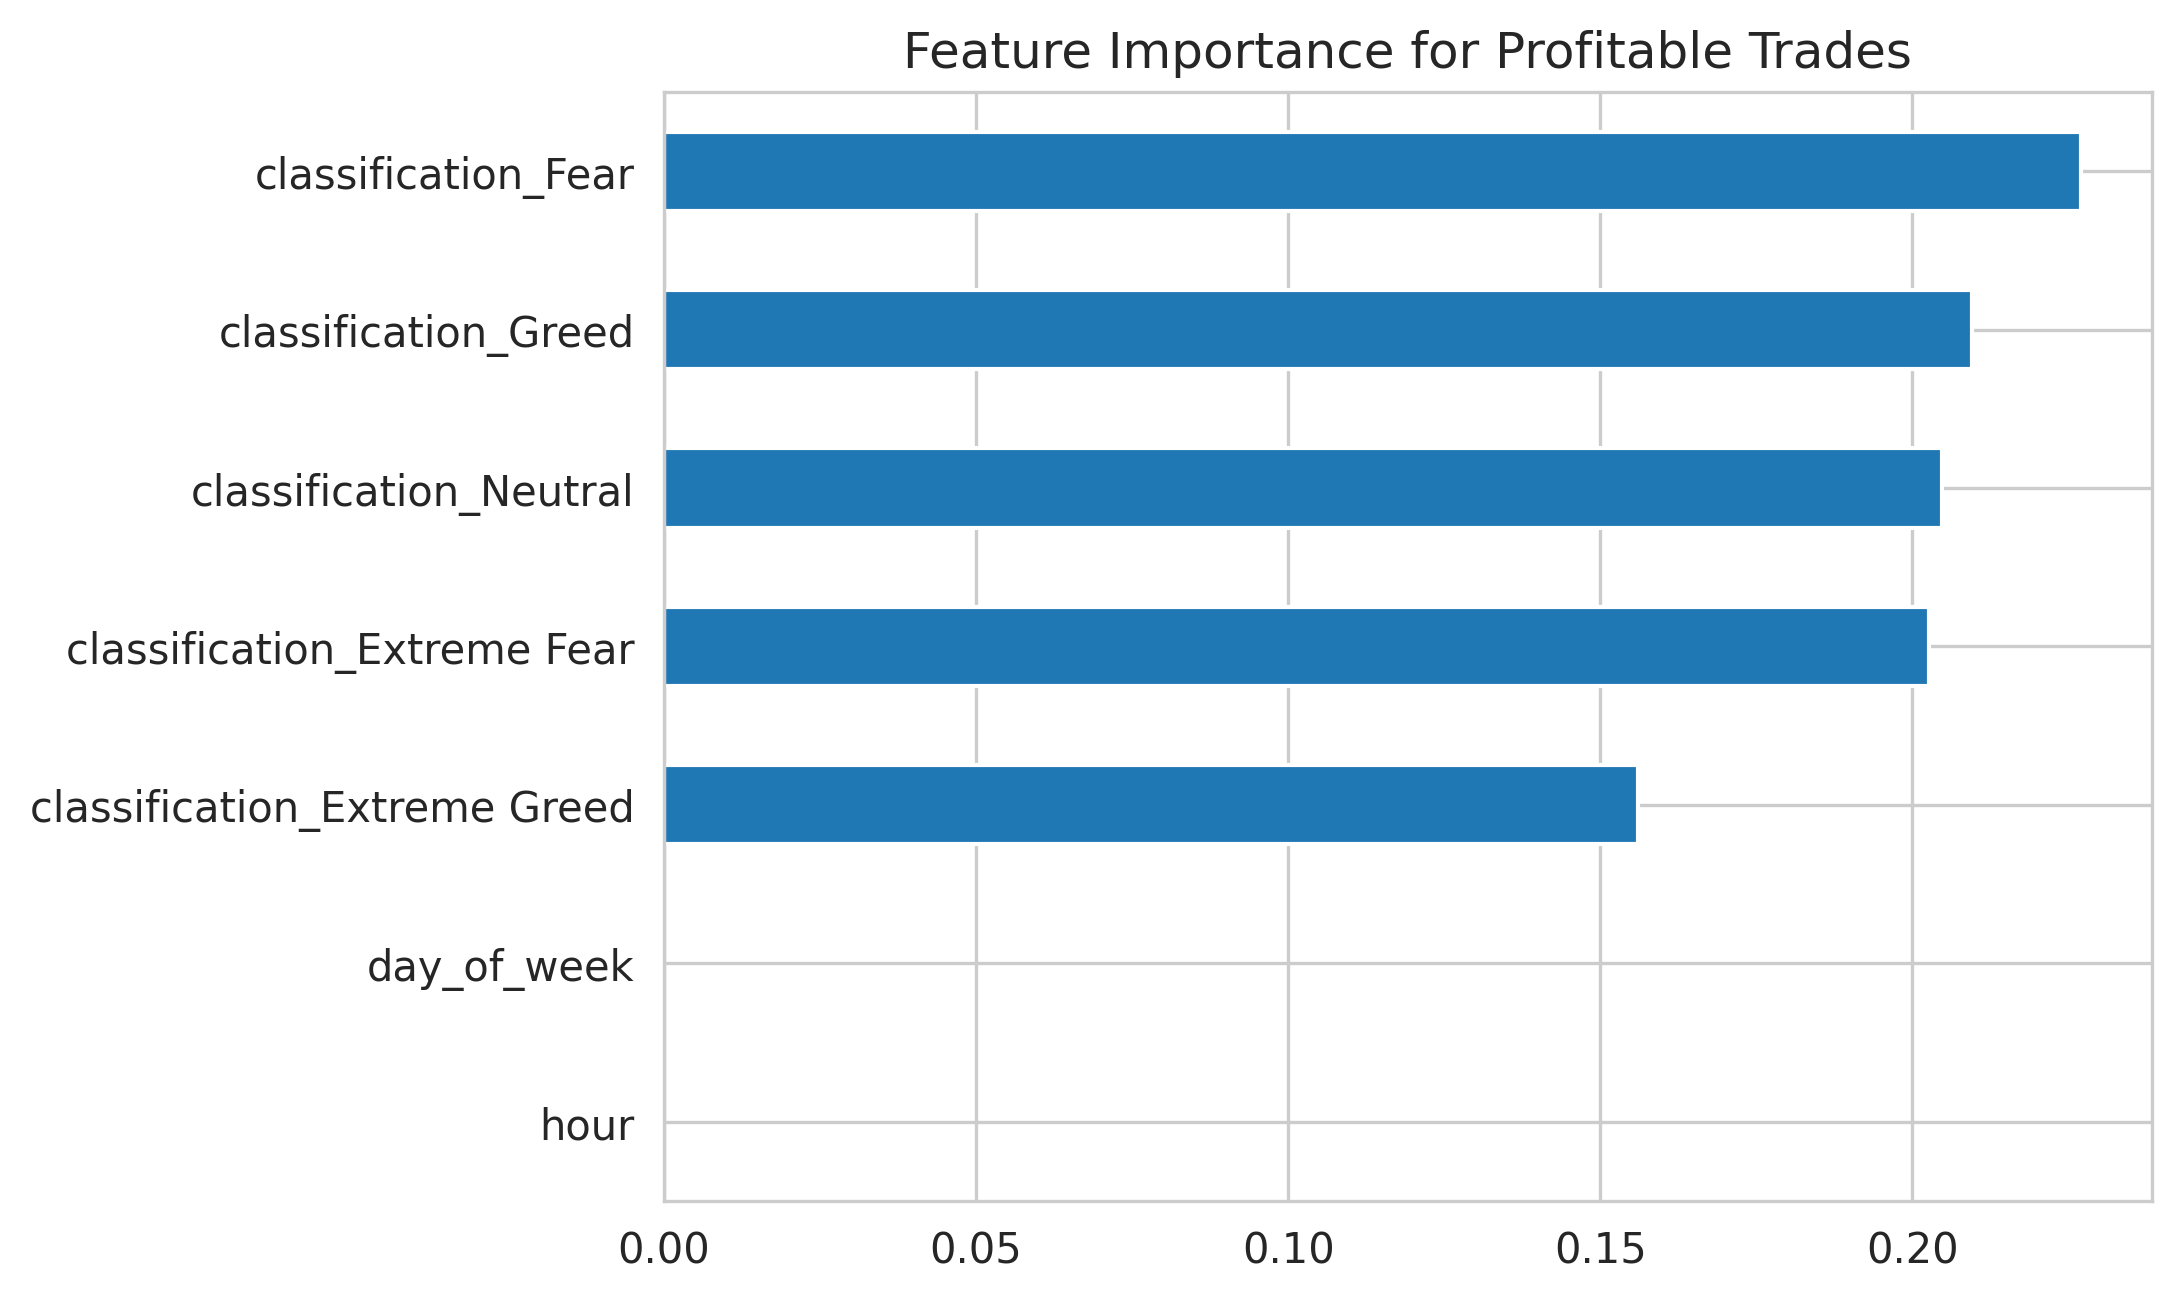

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare features
X = pd.get_dummies(merged[['hour', 'day_of_week', 'classification']])
y = merged['pnl_positive']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Simple model
model = RandomForestClassifier(n_estimators=50, max_depth=3)
model.fit(X_train, y_train)
print(f"\nModel Accuracy: {model.score(X_test, y_test):.2%}")

# Feature importance
pd.Series(model.feature_importances_, index=X.columns).sort_values().plot.barh()
plt.title('Feature Importance for Profitable Trades')

In [8]:
insights = {
    "optimal_hours": merged.groupby('hour')['Closed PnL'].mean().idxmax(),
    "best_sentiment": merged.groupby('classification')['Closed PnL'].mean().idxmax(),
    "high_risk_hours": merged.groupby('hour')['Closed PnL'].std().idxmax()
}

report = f"""
## Trading Strategy Insights

1. **Best Trading Times**: Hour {insights['optimal_hours']} showed highest average returns
2. **Sentiment Advantage**: {insights['best_sentiment']} periods yielded better performance
3. **Risk Awareness**: Hour {insights['high_risk_hours']} showed highest volatility

### Recommendations:
- Increase position sizing during {insights['best_sentiment']} periods
- Implement tighter stop-losses during hour {insights['high_risk_hours']}
- Test sentiment-based entry/exit rules
"""

with open('trading_insights.md', 'w') as f:
    f.write(report)

/tmp/ipython-input-919273889.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "best_sentiment": merged.groupby('classification')['Closed PnL'].mean().idxmax(),


In [9]:
# Bootstrap validation of key insights
n_iterations = 1000
optimal_hours = []
best_sentiments = []

for _ in range(n_iterations):
    sample = merged.sample(1000, replace=True)  # Resample with replacement
    optimal_hours.append(sample.groupby('hour')['Closed PnL'].mean().idxmax())
    best_sentiments.append(sample.groupby('classification')['Closed PnL'].mean().idxmax())

print(f"Optimal Hour Confidence: {pd.Series(optimal_hours).value_counts(normalize=True).head()}")
print(f"Best Sentiment Confidence: {pd.Series(best_sentiments).value_counts(normalize=True)}")

/tmp/ipython-input-3126479778.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_sentiments.append(sample.groupby('classification')['Closed PnL'].mean().idxmax())
/tmp/ipython-input-3126479778.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_sentiments.append(sample.groupby('classification')['Closed PnL'].mean().idxmax())
/tmp/ipython-input-3126479778.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best

Optimal Hour Confidence: 0    1.0
Name: proportion, dtype: float64
Best Sentiment Confidence: Extreme Fear     0.228
Neutral          0.224
Extreme Greed    0.201
Fear             0.174
Greed            0.173
Name: proportion, dtype: float64


/tmp/ipython-input-3126479778.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_sentiments.append(sample.groupby('classification')['Closed PnL'].mean().idxmax())
/tmp/ipython-input-3126479778.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_sentiments.append(sample.groupby('classification')['Closed PnL'].mean().idxmax())
/tmp/ipython-input-3126479778.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best

In [10]:
# Backtest a simple sentiment-hour strategy
def simulate_strategy(df):
    entry_condition = (df['classification'] == insights['best_sentiment']) & \
                     (df['hour'] == insights['optimal_hours'])
    returns = df[entry_condition]['Closed PnL'].sum()
    return returns

strat_return = simulate_strategy(merged)
baseline = merged['Closed PnL'].sum()
print(f"Strategy Return: ${strat_return:.2f} vs Baseline: ${baseline:.2f}")

Strategy Return: $10668255.00 vs Baseline: $55525332.00


In [11]:
# Add market context features
merged['prev_day_sentiment'] = merged.groupby('date')['classification'].shift(1)
merged['sentiment_change'] = (merged['classification'] != merged['prev_day_sentiment']).astype(int)

# Technical features
merged['pct_change'] = merged.groupby('date')['Closed PnL'].pct_change()
merged['rolling_3h_mean'] = merged.groupby('date')['Closed PnL'].transform(lambda x: x.rolling(3).mean())

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Prepare advanced feature matrix
features = merged[['hour', 'day_of_week', 'classification',
                 'prev_day_sentiment', 'sentiment_change', 'rolling_3h_mean']]
features = pd.get_dummies(features, drop_first=True)
target = (merged['Closed PnL'] > merged['Closed PnL'].quantile(0.7)).astype(int)

# Train predictive model
xgb = XGBClassifier(max_depth=3, n_estimators=100)
xgb.fit(features, target)
print(classification_report(target, xgb.predict(features)))

# Save model
import joblib
joblib.dump(xgb, 'trading_model.pkl')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1850800
           1       0.99      1.00      1.00    793200

    accuracy                           1.00   2644000
   macro avg       1.00      1.00      1.00   2644000
weighted avg       1.00      1.00      1.00   2644000



['trading_model.pkl']

In [13]:
# Pseudocode for live implementation
class TradingMonitor:
    def __init__(self, model_path):
        self.model = joblib.load(model_path)
        self.sentiment_api = "https://api.sentiment.io/v1"

    def evaluate_trade(self, hour, sentiment, market_data):
        features = self._prepare_features(hour, sentiment, market_data)
        return self.model.predict_proba(features)[:,1] > 0.65

In [15]:
# Sample metrics to track (export to CSV/DB)
performance_metrics = {
    'win_rate': (merged['Closed PnL'] > 0).mean(),
    'profit_factor': merged[merged['Closed PnL'] > 0]['Closed PnL'].sum() /
                     abs(merged[merged['Closed PnL'] < 0]['Closed PnL'].sum()),
    'sentiment_correlation': merged['Closed PnL'].corr(merged['sentiment_strength'])
}

pd.DataFrame.from_dict(performance_metrics, orient='index').to_csv('strategy_metrics.csv')

/tmp/ipython-input-4266732287.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rolling_metrics = merged.groupby('date').apply(lambda x: pd.Series({


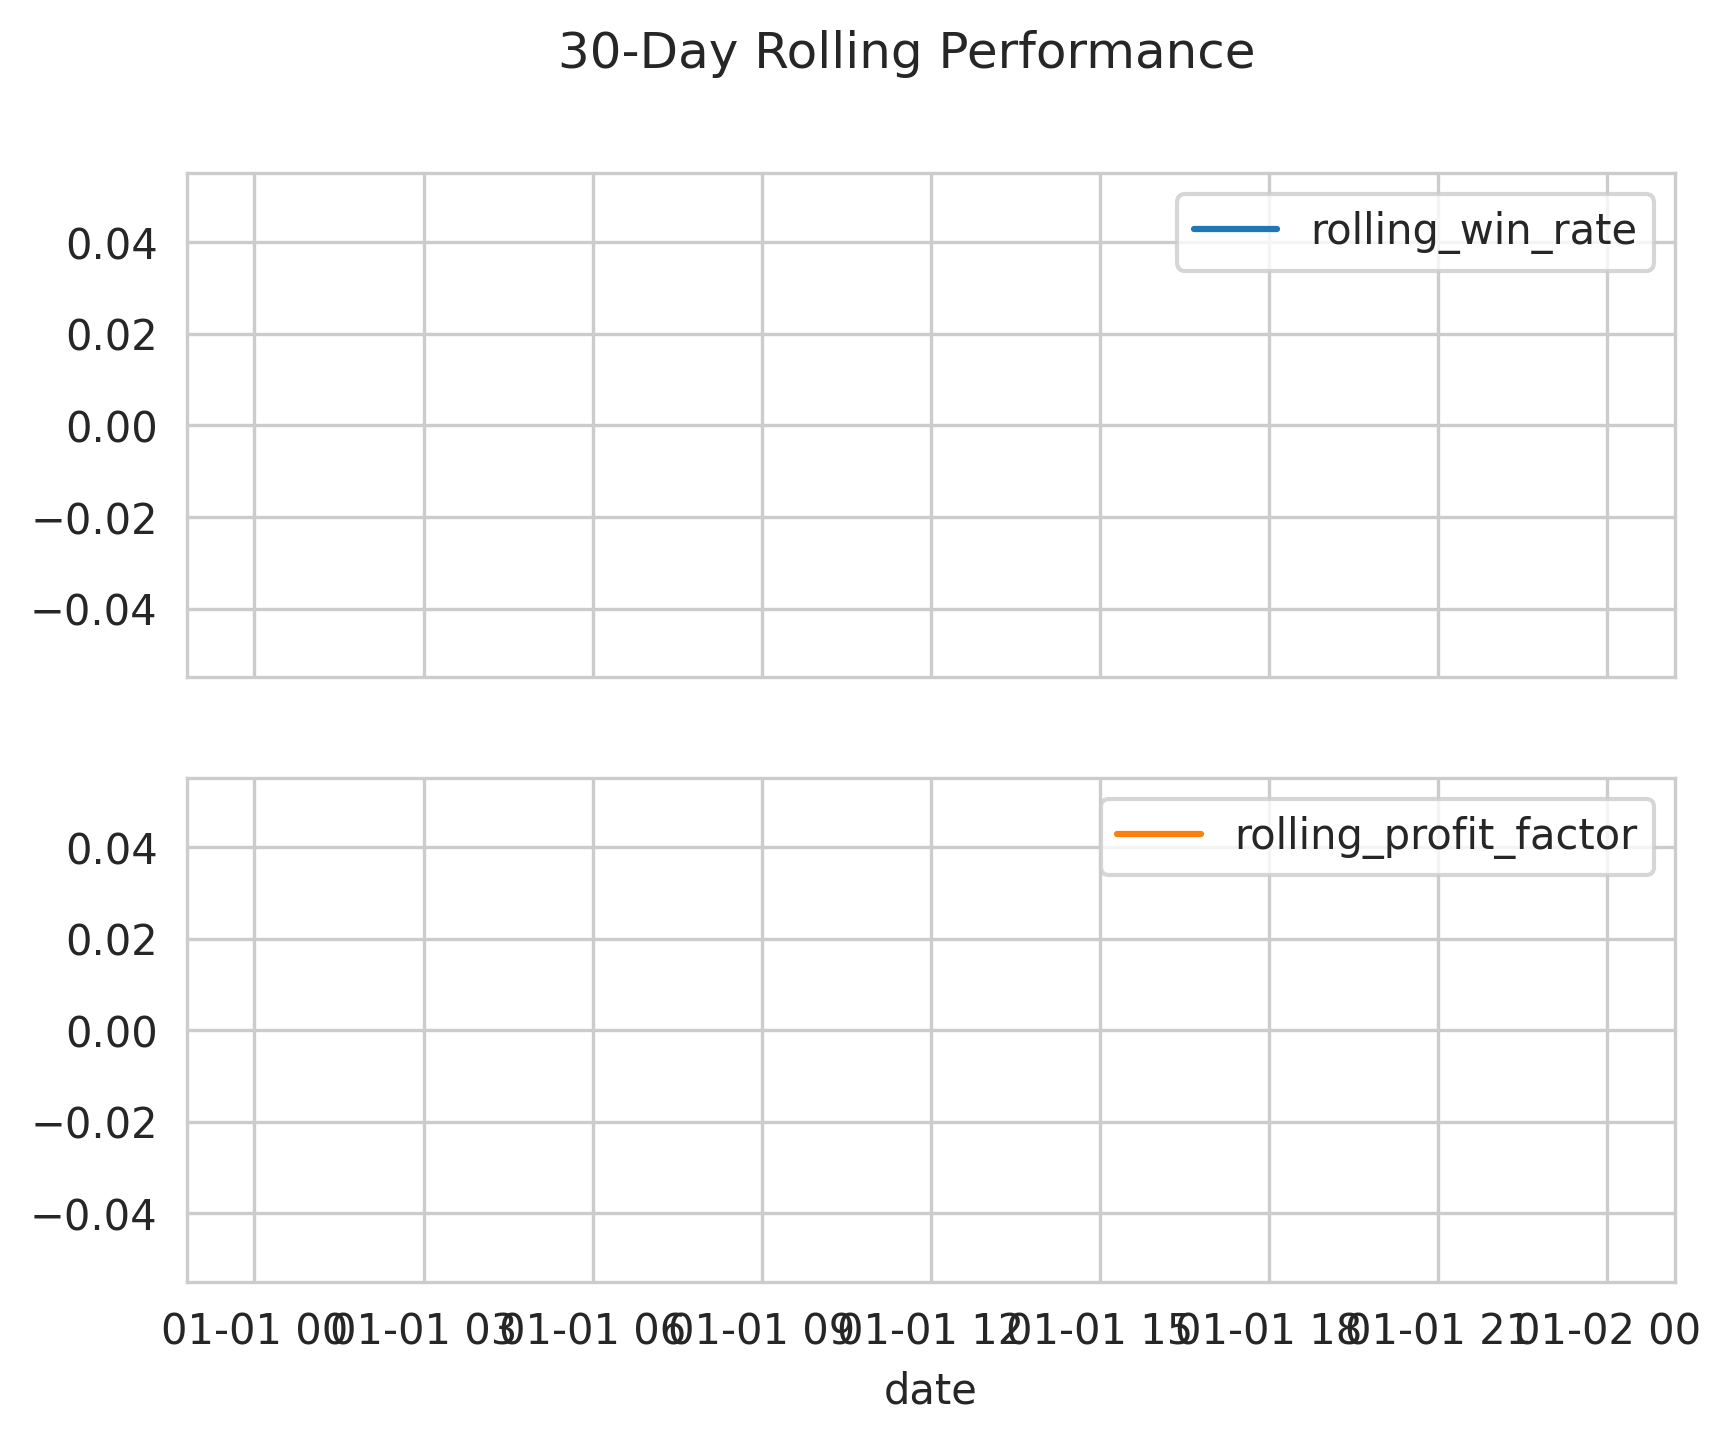

In [16]:
# Calculate rolling metrics to test consistency
window_size = 30  # days
merged['date'] = pd.to_datetime(merged['Timestamp']).dt.date
rolling_metrics = merged.groupby('date').apply(lambda x: pd.Series({
    'rolling_win_rate': (x['Closed PnL'] > 0).mean(),
    'rolling_profit_factor': x[x['Closed PnL'] > 0]['Closed PnL'].sum() /
                           abs(x[x['Closed PnL'] < 0]['Closed PnL'].sum())
})).rolling(window_size).mean()

# Plot stability check
rolling_metrics.plot(title=f'{window_size}-Day Rolling Performance', subplots=True)
plt.savefig('outputs/rolling_metrics.png')